<a href="https://colab.research.google.com/github/dcastf01/object_detection_TFM/blob/main/object_detection_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install TensorFlow2 Object Detection Dependencies

In [ ]:
#@title Tarjeta ofrecida por nvidia
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#@title Descargar repositorios e instalar librerias
# %%capture

import time
import pathlib
start_time = time.time()
!git clone https://github.com/dcastf01/colab_utils.git
!git clone https://github.com/dcastf01/object_detection_TFM.git
!pip install git+https://github.com/tensorflow/examples.git
!pip install tensorflow-addons
!pip install -U tfds-nightly
!pip install pydub
!pip install opencv-python-headless==4.2.0.34
!pip install tf_slim
!pip install pycocotools
# Clone the tensorflow models repository if it doesn't already exist

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models


Cloning into 'colab_utils'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 144 (delta 80), reused 25 (delta 12), pack-reused 0
Receiving objects: 100% (144/144), 162.65 KiB | 9.04 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Cloning into 'object_detection_TFM'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 209 (delta 81), reused 113 (delta 29), pack-reused 0
Receiving objects: 100% (209/209), 20.23 MiB | 7.55 MiB/s, done.
Resolving deltas: 100% (81/81), done.
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-s54twntw
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-s54twntw
  Created wheel for tensorflow-examples: filename=tensorflow_examples-937f69c82766ec5a34e88bb47897f6735ce992f4_-cp36-none-any.w

In [ ]:
#@title Install the Object Detection API
# %%capture
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1615233 sha256=a4e83bf0329d545244e9455c07a09b28999f080ddeb54fcf524b9df0fa7914df
  Stored in directory: /tmp/pip-ephem-wheel-cache-pb4f93l0/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=b88a6ca3bf4a68f042bde514b826f8388d19979681dcd7e056337c428e42f6c9
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=0531b5ef52ec383fd5658a39fca514c7b713092cef6483f5e2b655345eeb7898
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=518d8574e588bbbce9c9b53f9ca7285420b32fe993772e6ca2cd33

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [ ]:
#@title Library and check api object detection is ok

import matplotlib
import matplotlib.pyplot as plt

import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import os, sys, math

tfds.disable_progress_bar()

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

from colab_utils.utils import notification

%matplotlib inline

#run model builder test
run_builder_test=False #@param {type:"boolean"}

if run_builder_test:
    !python /content/models/research/object_detection/builders/model_builder_tf2_test.py

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.1
Running on CPU
Number of accelerators:  1


In [ ]:
#@title Creating path

import pathlib


path_annotation="/content/workspace/annotations/"         #@param {type:"string"}
path_exported_models="/content/workspace/exported-models/"  #@param {type:"string"}
path_model= "/content/workspace/models/" #@param {type:"string"}
path_pre_trained_models="/content/workspace/pre-trained-models/" #@param {type:"string"}
path_images= "/content/workspace/images/" #@param {type:"string"}

os.makedirs(path_annotation, exist_ok=True)
os.makedirs(path_exported_models, exist_ok=True)
os.makedirs(path_model, exist_ok=True)
os.makedirs(path_pre_trained_models, exist_ok=True)
os.makedirs(path_images,exist_ok=True)
            
label_map_pbtxt_fname = "/content/workspace/annotations/label_map.pbtxt" #@param {type:"string"} 

# Prepare Dataset
En esta sección se decide el dataset que se va a utilizar, se puede crear un nuevo dataset de forma customizada con Tf.dataset, más información ver [aqui](https://www.tensorflow.org/guide/data)

*   Disponible el dataset [cars196](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) 

>*  La ventaja es su fácil implementación y cantidad de vehículos que tiene, la desventaja es que no solo tiene vehículos con vista frontal o trasera que es la mejor forma de discriminar los vehículos

*   Pendiente el dataset [compcars](http://mmlab.ie.cuhk.edu.hk/datasets/comp_cars/)

>* La ventaja es que dispone de las imagenes de los vehículos clasificadas también en la posición que han sido tomadas la desventaja principal es que no se encuentra en la api de tensorflow, por lo que habría que incluirlo manualmente



In [ ]:
#@title Decide which dataset you use, in this moment only available cars196
%%time
%cd /content
Which_dataset = "compcars" #@param ["cars196","compcars","subset_of_compcars","custom"]


SIZE=256 #@param {type:"integer"} 
IMAGE_SIZE=[SIZE,SIZE]
SEED=1 #@param {type:"integer"} 

# BATCH_SIZE = 1 #@param {type:"integer"} 
BUFFER_SIZE = 1000 #@param {type:"integer"} 
visible_classes = 28 #@param {type:"slider", min:1, max:196, step:1}


if Which_dataset=="cars196":
  from object_detection_TFM.dataset.cars196 import cars196
  cars196.Cars196()
  cars_builder=tfds.builder("cars196")
  cars_builder.download_and_prepare(download_dir=path_images)

  repository_class=getattr(tfds.image_classification,Which_dataset)
  classlabel=repository_class._NAMES
  num_class=len(classlabel)


  table_format = '| {0: >2} | {1: <40} |'
  header = table_format.format("id", "name")
  print( "The dataset you will use is "+ Which_dataset)
  print(header)
  print("-" * len(header))
  for id,label in zip(range(visible_classes),classlabel[:visible_classes]):
    print(table_format.format(
          id, label))
    
elif Which_dataset=="compcars":
  from colab.utils.download_file_from_drive import download_file_from_google_drive
  file_id="18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg"
  destination="/content/file.zip"
  download_file_from_google_drive(file_id,destination)

elif Which_dataset=="subset_of_compcars":

  from colab.utils.download_file_from_drive import download_file_from_google_drive

  file_id = '1MKjn9qLc2o82Vk1Rua-7TTOmxrOAWi6U
  destination = '/content/file.zip'

  download_file_from_google_drive(file_id, destination)

elif Which_dataset=="custom":
  print("pendiente crear el upload de imagenes correspondientes")

else:
  print("el dataset no se encuentra disponible")

from colab_utils.utils import notification
notification.set_sound_notification()

end_time = time.time()
elapsed_time = end_time - start_time
print('Setup time: ' + str(elapsed_time) + ' s')

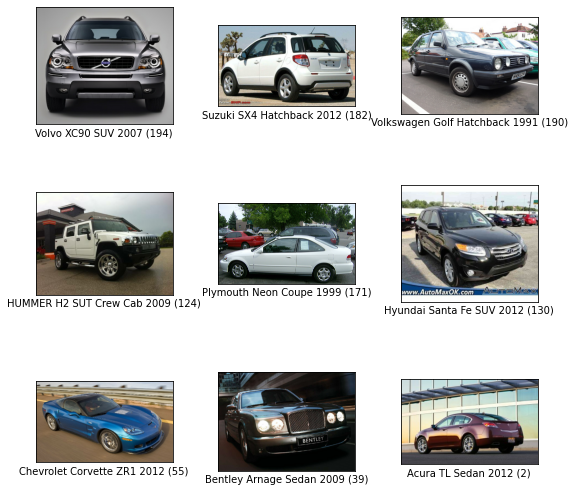

tfds.core.DatasetInfo(
    name='cars196',
    full_name='cars196/2.0.0',
    description="""
    The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
    """,
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    data_path='/root/tensorflow_datasets/cars196/2.0.0',
    download_size=1.82 GiB,
    dataset_size=1.86 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'filename': Text(shape=(), dtype=tf.string),
        'filepath': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInf

In [ ]:
#@title Split and show Dataset and format of tensor
if Which_dataset=="cars196":
  (ds_train, ds_valid, ds_test), info = tfds.load(Which_dataset,
                                  split=['train', 'test[50%:]', 'test[:50%]'],    
                                  as_supervised=False,
                                  with_info=True
                                  )
  tfds.show_examples(ds_train,info)
  print(info)
  NUM_CLASSES=len(classlabel) 
  TRAIN_LENGTH = info.splits['train'].num_examples
  TEST_LENGTH=info.splits["test"].num_examples/2 #only use test 50%
  VAL_LENGTH=info.splits['test'].num_examples/2#only use test 50%
  print(ds_train)

#Object detection to detect car

Utilizar esta sección para la extracción de los vehículos para utilizar a posterior esas imágenes en la red neuronal de clasificación de vehículo

Se compone de tres secciones


1.   setup inicial para elegir el modelo correspondiente
2.   Se puede realizar un entrenamiento si se cree necesario (no se recomienda) 
3.   Utilizar el modelo entrenado o un modelo pre-entrenado para la extración de la caja de vehículos. 
> se recomienda utilizar el modelo pre-entrenado en el dataset coco, ya que ya está entrenado para detectar vehículos entre sus clases. 


In [ ]:
#@title Setup to object detection to detect car
##change chosen model to deploy different models available in the TF2 object detection zoo
you_want_train_model = False #@param {type:"boolean"}
you_want_eval_model=False #@param {type:"boolean"}

you_want_inference=True #@param {type:"boolean"}
you_use_model_pre_trained_with_predefined_classes=True#@param{type:"boolean"}

MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
    },
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0' #@param ["efficientdet-d0","efficientdet-d1","efficientdet-d2","efficientdet-d3"]


num_steps = 4000 #@param {type:"integer"} 
#The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #@param {type:"integer"} 
#Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size =  8#@param {type:"integer"} #if you can fit a large batch in memory, it may speed up your training
max_detections_per_class= 1#@param {type:"integer"} 

#download pretrained weights

%cd {path_pre_trained_models}
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

#download base training configuration file
%cd {path_model}
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

#download base training configuration file
%cd {path_model}
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

#prepare
pipeline_fname = path_model+ base_pipeline_file
fine_tune_checkpoint = path_pre_trained_models + model_name + '/checkpoint/ckpt-0'




/content/workspace/pre-trained-models
--2021-01-20 15:02:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M   173MB/s    in 0.2s    

2021-01-20 15:02:46 (173 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

/content/workspace/models
--2021-01-20 15:02:46--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133,

## Train Custom detect car

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







### Configure Custom TensorFlow2 Object Detection Training Configuration

In [ ]:
#@title Create the TFrecord, labelmap and the custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file
if you_want_train_model:
  from object_detection_TFM.dataset.cars196 import create_tfrecord

  from object_detection_TFM.dataset import create_labelmap
  classlabel
  
  create_tfrecord.write_TFrecord(ds_train,classlabel,path_annotation,"train")

  create_tfrecord.write_TFrecord(ds_test,classlabel,path_annotation,"test")

  train_record_fname = path_annotation+"train.record"
  test_record_fname = path_annotation+"test.record"
  # classlabel=["car"]
  create_labelmap.label_map_v1(classlabel,label_map_pbtxt_fname)

  def get_num_classes(pbtxt_fname):
      from object_detection.utils import label_map_util
      label_map = label_map_util.load_labelmap(pbtxt_fname)
      categories = label_map_util.convert_label_map_to_categories(
          label_map, max_num_classes=200, use_display_name=True)
      category_index = label_map_util.create_category_index(categories)
      return len(category_index.keys())
  num_classes = get_num_classes(label_map_pbtxt_fname)

  import re


  %cd path_model
  print('writing custom configuration file')

  with open(pipeline_fname) as f:
      s = f.read()
  with open('pipeline_file.config', 'w') as f:
      
      # fine_tune_checkpoint
      s = re.sub('fine_tune_checkpoint: ".*?"',
                'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
      
      # tfrecord files train and test.
      s = re.sub(
          '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
      s = re.sub(
          '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

      # label_map_path
      s = re.sub(
          'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

      # Set training batch_size.
      s = re.sub('batch_size: [0-9]+',
                'batch_size: {}'.format(batch_size), s)

      # Set training steps, num_steps
      s = re.sub('num_steps: [0-9]+',
                'num_steps: {}'.format(num_steps), s)
      
      # Set number of classes num_classes.
      s = re.sub('num_classes: [0-9]+',
                'num_classes: {}'.format(num_classes), s)
      # # Set max number of detections.
      # s = re.sub('max_detections_per_class: [0-9]+',
      #            'max_detections_per_class: {}'.format(max_detections_per_class), s)
      
      #fine-tune checkpoint type
      s = re.sub(
          'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
          
      f.write(s)


  %cat "/content/workspace/models/pipeline_file.config"
  notification.set_sound_notification()
  pipeline_file = path_model+'pipeline_file.config'
  model_dir = path_model

In [ ]:
#@title Load the tensorboard and click in the url to check bigger

%load_ext tensorboard
#aquí estaría bien añadir mis utils
%tensorboard --logdir {model_dir}
# %tensorboard --logdir /content/workspace/models/
# %tensorboard --logdir /content/workspace/test/efficientdet_d5_coco17_tpu-32/checkpoint
import os
from colab_utils.tensorboard import tensorboard as utils_tsboard

# set paths
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, model_dir)

# will install `ngrok`, if necessary
# will create `log_dir` if path does not exist
utils_tsboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )
print("click in the tensorboard url")
# import os
# from colab_utils.tensorboard import tensorboard as utils_tsboard

# # set paths
# ROOT = %pwd
# LOG_DIR = os.path.join(ROOT, model_dir)

# # will install `ngrok`, if necessary
# # will create `log_dir` if path does not exist
# utils_tsboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )
# print("click in the tensorboard url")

###Train phase

In [ ]:
#@title Train the model

if you_want_train_model:
  !python /content/models/research/object_detection/model_main_tf2.py \
      --pipeline_config_path={pipeline_file} \
      --model_dir={model_dir} \
      --alsologtostderr \
      --num_train_steps={num_steps} \
      --sample_1_of_n_eval_examples=1 \
      --num_eval_steps={num_eval_steps}

  notification.set_sound_notification()

else:
  print("you don't want train the model")

In [ ]:
#@title Evaluate the model (somethins is break in the test tfrecord)

if you_want_eval_model:
  # run model evaluation to obtain performance metrics
  !python /content/models/research/object_detection/model_main_tf2.py \
      --pipeline_config_path={pipeline_file} \
      --model_dir={model_dir} \
      --checkpoint_dir=/content/workspace/pre-trained-models/efficientdet_d0_coco17_tpu-32/checkpoint \
      # --checkpoint_dir={model_dir} \
  # Not yet implemented for EfficientDet

### Exporting a Trained Inference Graph

In [ ]:
#see where our model saved weights
%ls {path_model}

checkpoint                  ckpt-4.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-4.index
ckpt-1.index                ngrok*
ckpt-2.data-00000-of-00001  pipeline_file.config
ckpt-2.index                ssd_efficientdet_d0_512x512_coco17_tpu-8.config
ckpt-3.data-00000-of-00001  ssd_efficientdet_d0_512x512_coco17_tpu-8.config.1
ckpt-3.index                train/


In [ ]:
#@title exported the model

#run conversion script
import re
import numpy as np

output_directory = path_exported_models

#place the model weights you would like to export here
last_model_path = path_model
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

In [ ]:
%ls {last_model_path}

ngrok*                ssd_efficientdet_d0_512x512_coco17_tpu-8.config
pipeline_file.config  ssd_efficientdet_d0_512x512_coco17_tpu-8.config.1


## Run Inference on Images to detect car and use in the next phase



In [ ]:
#@title load the model
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

basepath="/content/data"

if you_use_model_pre_trained_with_predefined_classes:
  from object_detection_TFM.dataset.coco import mscoco_dictionary

  category_index=mscoco_dictionary.category_index
  path_model=path_pre_trained_models+model_name+"/"
  
  model_to_inference=path_model+"checkpoint/"

  pipeline_config = path_model+"pipeline.config"

else:
  
  label_map_path=label_map_pbtxt_fname
  label_map = label_map_util.load_labelmap(label_map_path)
  categories = label_map_util.convert_label_map_to_categories(
      label_map,
      max_num_classes=label_map_util.get_max_label_map_index(label_map),
      use_display_name=True)
  category_index = label_map_util.create_category_index(categories)
  label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
  model_to_inference=last_model_path
  pipeline_config=pipeline_file

#recover our saved model

#generally you want to put the last ckpt from training in here
model_dir = model_to_inference+'ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_to_inference+'ckpt-0'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)
%cd /content

tf.Tensor(194, shape=(), dtype=int64)
Elapsed time: 0.6295757293701172 second por prediccion de imagen
Elapsed time: 0.6295757293701172 second por prediccion y copia de la imagen de imagen


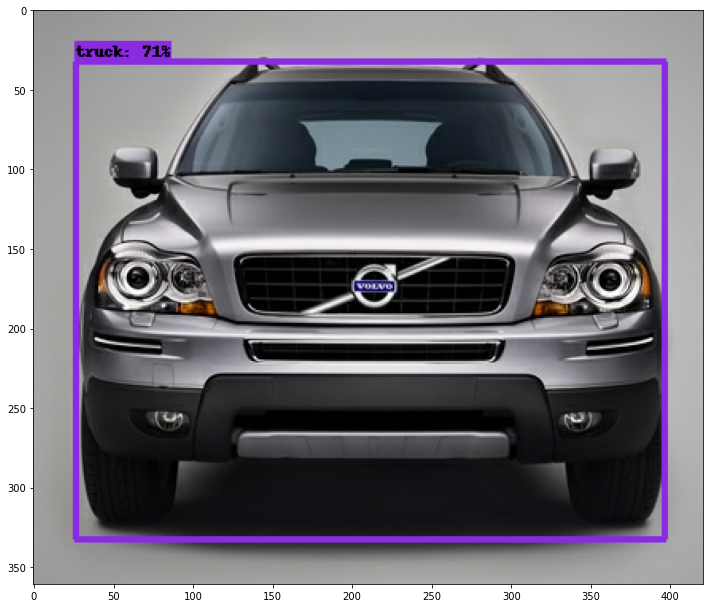

Elapsed time: 0.6295757293701172 second per image
tf.Tensor(182, shape=(), dtype=int64)
Elapsed time: 0.7376019954681396 second por prediccion de imagen
Elapsed time: 0.7376019954681396 second por prediccion y copia de la imagen de imagen


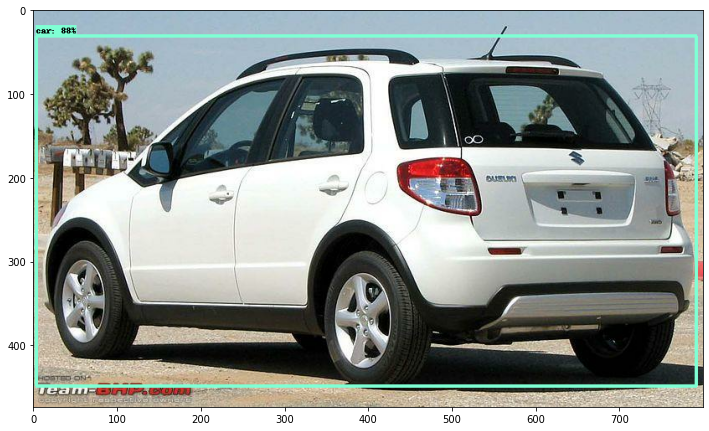

Elapsed time: 0.6835888624191284 second per image
tf.Tensor(190, shape=(), dtype=int64)
Elapsed time: 0.694425106048584 second por prediccion de imagen
Elapsed time: 0.694425106048584 second por prediccion y copia de la imagen de imagen


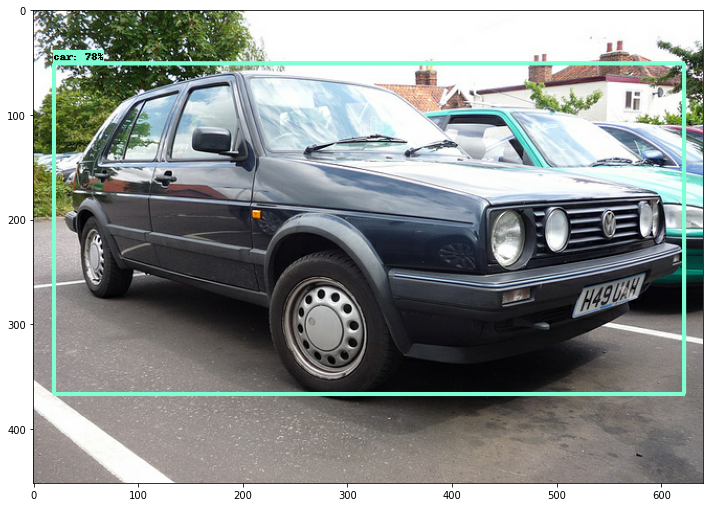

Elapsed time: 0.6872009436289469 second per image
tf.Tensor(124, shape=(), dtype=int64)
Elapsed time: 0.7473726272583008 second por prediccion de imagen
Elapsed time: 0.7473726272583008 second por prediccion y copia de la imagen de imagen


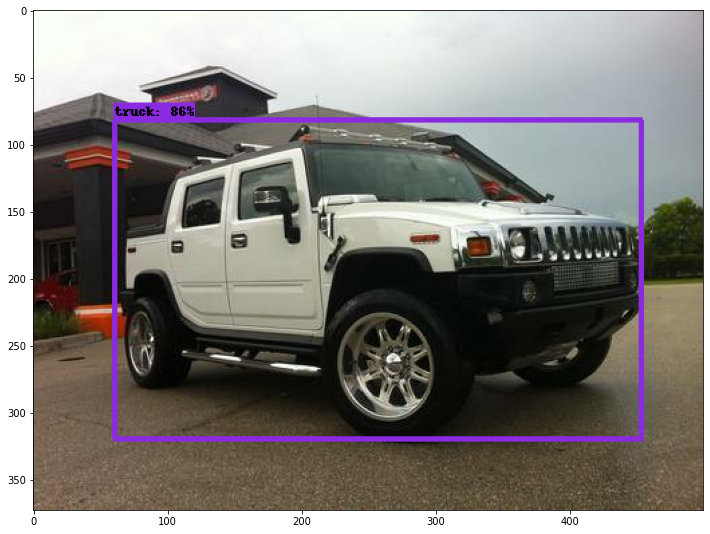

Elapsed time: 0.7022438645362854 second per image


tf.Tensor(171, shape=(), dtype=int64)
Elapsed time: 12.994198322296143 second por prediccion de imagen
Elapsed time: 12.994198322296143 second por prediccion y copia de la imagen de imagen


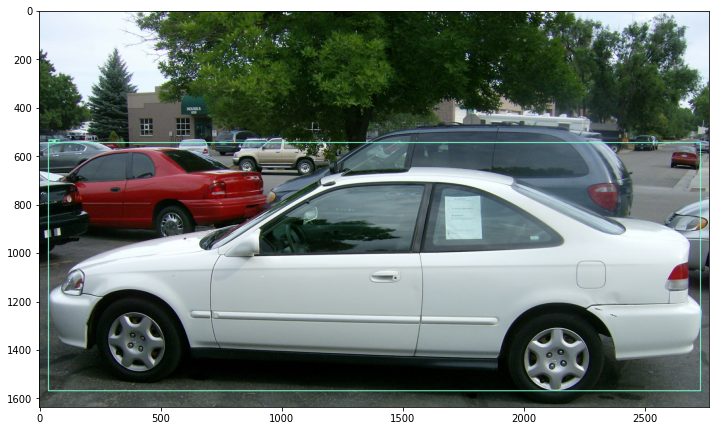

Elapsed time: 3.160634756088257 second per image


tf.Tensor(130, shape=(), dtype=int64)
Elapsed time: 13.477972984313965 second por prediccion de imagen
Elapsed time: 13.477972984313965 second por prediccion y copia de la imagen de imagen


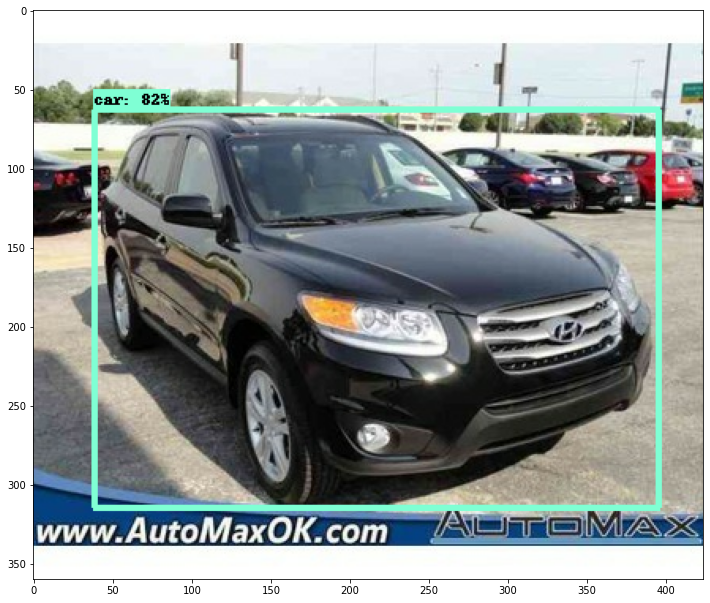

Elapsed time: 4.8801911274592085 second per image


tf.Tensor(55, shape=(), dtype=int64)
Elapsed time: 13.085405588150024 second por prediccion de imagen
Elapsed time: 13.085405588150024 second por prediccion y copia de la imagen de imagen


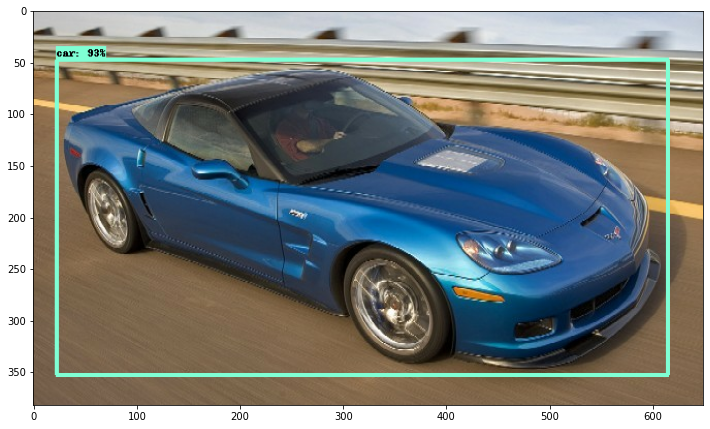

Elapsed time: 6.05236462184361 second per image


tf.Tensor(39, shape=(), dtype=int64)
Elapsed time: 13.275210857391357 second por prediccion de imagen
Elapsed time: 13.275210857391357 second por prediccion y copia de la imagen de imagen


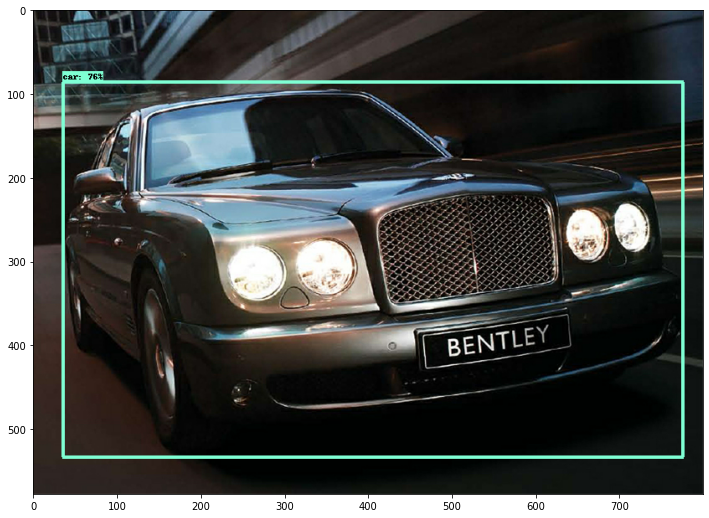

Elapsed time: 6.955220401287079 second per image


tf.Tensor(2, shape=(), dtype=int64)
Elapsed time: 13.347878456115723 second por prediccion de imagen
Elapsed time: 13.347878456115723 second por prediccion y copia de la imagen de imagen


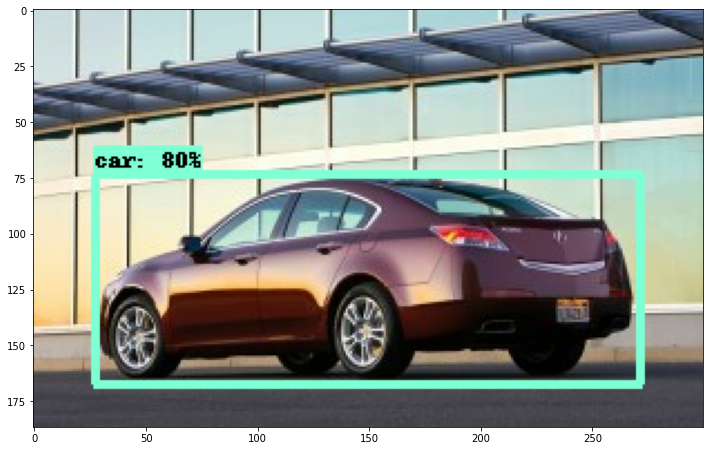

Elapsed time: 7.665515740712483 second per image


KeyboardInterrupt: ignored

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
from object_detection_TFM.detect_object.using_api_tensorflow.utils import ( create_folder,
                                                                          copy_image_to_next_dataset,
                                                                          crop_image,
                                                                          crop_image_and_copy_next_dataset)

elapsed = []

create_folder(range(0,num_class),basepath="/content/data")
for complete_tensor in ds_train:
  image=complete_tensor["image"]
  image_np=image.numpy()
  input_tensor=tf.cast(tf.expand_dims(image,axis=0),tf.float32)
  start_time = time.time()
  detections, predictions_dict, shapes = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)
  # print(detections['detection_classes'][0].numpy()[0])
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
 
  filename=complete_tensor["filename"]
  label=complete_tensor["label"]
  print(label)

  bbox=detections["detection_boxes"][0][0]
  print('Elapsed time: ' + str(elapsed[-1]) + ' second por prediccion de imagen')
  if detections['detection_classes'][0][0]+label_id_offset in [3,6,8]:
    crop_image_and_copy_next_dataset(image,bbox,filename,label)
    print('Elapsed time: ' + str(elapsed[-1]) + ' second por prediccion y copia de la imagen de imagen')
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=.5,
        agnostic_mode=False,
  )

  plt.figure(figsize=(12,16))
  plt.imshow(image_np_with_detections)
  plt.show()
  mean_elapsed = sum(elapsed) / float(len(elapsed))
  print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

#Classification of car
Utilizar esta sección para la extracción del modelo y marcá del vehículo
Se compone de tres secciones


1.   Generación del dataset
> Se aprovecha para realizar augmentación a las imágenes
2.   Creación del modelo
3.   Entrenamiento del modelo
> Destacar que con el dataset cars196 los resultados del dataset de test es del 20% (196 clases diferentes) probablemente a que los vehículos están introducidos en todo tipo de vistas. Por lo que se intentará actualizar este notebook con el dataset de compcars
4. Inferencia
> Realizar predicciones de imágenes entrantes


##Dataset

In [ ]:
#@title Create dataset to train
PROBABLITY_THRESHOLD = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
#PERCENT_INCREMENTED_IN_JITTER value recomended 0.11
PERCENT_INCREMENTED_IN_JITTER= 0.11 #@param {type:"slider", min:0, max:0.25, step:0.01}
AUGMENTED = True #@param {type:"boolean"}
BATCH_SIZE = 32 #normalmente en 32 
SIZE=224#@param {type:"integer"}
IMAGE_SIZE=[SIZE,SIZE]
IMG_HEIGHT = SIZE 
IMG_WIDTH = SIZE

#ver posibilidad de eliminar esta parte de abajo y llamar directamente a la clase augmented que he creado
@tf.function
def crop_image_and_normalize_and_augmented(tensor,augmented=True):
  def crop_image(img,bbox):
   #las cajas siguen esta convención ymin, xmin, ymax, xmax
    shape=img.get_shape()
    width=shape[0]
    height=shape[1]

    # ymin, xmin, ymax, xmax=bbox
    ymin=tf.cast(tf.multiply(bbox[0],height),tf.int32)
    ymax=tf.cast(tf.multiply(bbox[2],height),tf.int32)
    xmin=tf.cast(tf.multiply(bbox[1],width),tf.int32)
    xmax=tf.cast(tf.multiply(bbox[3],width),tf.int32)

    result= tf.image.crop_to_bounding_box(img, xmin, ymin, 
                                        xmax-xmin, ymax-ymin)
    return result

  def resize(img,height,width):

    img=tf.image.resize(img,[height,width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
    return img

  def normalize(img):
    
    img=tf.keras.applications.imagenet_utils.preprocess_input(img,mode="tf")
 
    return img

  def random_jitter(img,height,width):
    
    incremented=PERCENT_INCREMENTED_IN_JITTER
    height_incremented=int(height*(1+incremented))
    width_incremented=int(width*(1+incremented))
    img = resize(img,height_incremented,width_incremented)
    
    img = tf.image.random_crop(img, size=[height,width,3])
    
    return img
  def flip_image(img: tf.Tensor):
    """Flip augmentation

    Args:
        img: Image

    Returns:
        Augmented image
    """
    if tf.random.uniform(()) > PROBABLITY_THRESHOLD :
    
      img=tf.image.flip_left_right(img)
    return img
  
  def color(img: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        img: Image

    Returns:
        Augmented image
    """
    if tf.random.uniform(()) > PROBABLITY_THRESHOLD :
      img = tf.image.random_hue(img, 0.08)
    if tf.random.uniform(()) > PROBABLITY_THRESHOLD :
      img = tf.image.random_saturation(img, 0.6, 1.6)
    if tf.random.uniform(()) > PROBABLITY_THRESHOLD :
      img = tf.image.random_brightness(img, 0.05)
    if tf.random.uniform(()) > PROBABLITY_THRESHOLD :
      img = tf.image.random_contrast(img, 0.7, 1.3)
    
    return img

  def encode_label(label):
    return tf.one_hot(label,NUM_CLASSES)


  img=tensor["image"]
  img=tf.ensure_shape(tf.cast(tf.py_function(crop_image, [img,tensor["bbox"]], [tf.uint8]),tf.float32),[None,None, None, 3])
  
  img=tf.squeeze(img,[0])
  img=resize(img,IMG_HEIGHT,IMG_WIDTH)

  if augmented:
    img=random_jitter(img,IMG_HEIGHT,IMG_WIDTH)
    img=flip_image(img)
    img=color(img)
    

  img=normalize(img)
  img=tf.clip_by_value(img, -1, 1)

  label=encode_label(tensor["label"])
  return img,label

@tf.function
def load_train_image(tensor):
  return crop_image_and_normalize_and_augmented(tensor,AUGMENTED)
@tf.function
def load_test_image(tensor):

  return crop_image_and_normalize_and_augmented(tensor)





In [ ]:
if Which_dataset=="cars196":
  ds_cutimage_train=ds_train.map(load_train_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_cutimage_train=ds_cutimage_train.cache().shuffle(100).batch(BATCH_SIZE)

  ds_cutimage_valid=ds_valid.map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_cutimage_valid=ds_cutimage_valid.cache().shuffle(100).batch(BATCH_SIZE)

  ds_cutimage_test=ds_test.map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_cutimage_test=ds_cutimage_test.cache().shuffle(100).batch(BATCH_SIZE)


##Model

In [ ]:
#@title Device detect
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on  1  GPU(s) 
Number of accelerators:  1


In [ ]:
#@title Create model
#it is recommended to only use batchnormalization
MODEL_WITH_BATCHNORMALIZATION = True #@param {type:"boolean"}
MODEL_WITH_DROPOUT = True #@param {type:"boolean"}
value_dropout = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
NUM_CLASS=len(classlabel)#depende del numero de clases


with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)

  bnmomemtum=0.9
  def fire(x, squeeze, expand):
   
    if MODEL_WITH_BATCHNORMALIZATION:
      x=tf.keras.layers.BatchNormalization()(x)
    if MODEL_WITH_DROPOUT:
      x=tf.keras.layers.Dropout(value_dropout)(x)
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    
    y1 = tf.keras.layers.Conv2D(filters=expand, kernel_size=1, activation='relu', padding='same')(y)
 
    y3 = tf.keras.layers.Conv2D(filters=expand, kernel_size=3, activation='relu', padding='same')(y)
   
   
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)
    
  def fire_with_bypass(x, squeeze, expand):
    
    if MODEL_WITH_BATCHNORMALIZATION:
      x=tf.keras.layers.BatchNormalization()(x)
    #if con_dropout:
     # x=tf.keras.layers.Dropout(value_dropout)(x)
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)

    y1 = tf.keras.layers.Conv2D(filters=expand, kernel_size=1, activation='relu', padding='same')(y)
 
    y3 = tf.keras.layers.Conv2D(filters=expand, kernel_size=3, activation='relu', padding='same')(y)
   
    y5=tf.keras.layers.concatenate([y1, y3])
    return tf.keras.layers.add([x, y5])

  def fire_module_with_bypass(squeeze, expand):
    return lambda x: fire_with_bypass(x, squeeze, expand)
 
  x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=95,strides=2, use_bias=True, activation='relu')(x)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(16, 64)(y)
  y = fire_module_with_bypass(16, 64)(y)
  y = fire_module(32, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module_with_bypass(32, 128)(y)
  y = fire_module(48, 192)(y)
  y = fire_module_with_bypass(48, 192)(y)
  y = fire_module(64, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module_with_bypass(64, 256)(y)
  
  if MODEL_WITH_BATCHNORMALIZATION:
    y=tf.keras.layers.BatchNormalization()(y)
  if MODEL_WITH_DROPOUT:
      y=tf.keras.layers.Dropout(value_dropout)(y)
  y = tf.keras.layers.Conv2D(kernel_size=3, filters=NUM_CLASS,strides=2, use_bias=True, activation='relu')(y) #en el modelo el numero de filtros es igual al número de clases
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(NUM_CLASS, activation='softmax')(y) 

  #revisar para disminuir el número de clases


  model = tf.keras.Model(x, y)

 # initiate RMSprop optimizer
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.0005, decay=1e-6)

  METRICS=[ 
      
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      tf.keras.metrics.Accuracy(name="accuracy_binary"),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',num_thresholds=500),#cambiar el auc
      tf.keras.metrics.TopKCategoricalAccuracy( k=3, name='top_3_categorical_accuracy'),
      tf.keras.metrics.TopKCategoricalAccuracy( k=5, name='top_5_categorical_accuracy'),
      tf.keras.metrics.TopKCategoricalAccuracy( k=10, name='top_10_categorical_accuracy')
        ]
    # Let's train the model using RMSprop
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=METRICS)
 #model.summary()


In [ ]:
#@title if you execute the cell you have a plot of model

plot_model(model, to_file='model.png',show_shapes=True,)


##Train

In [ ]:
model_dir="/content/tensorboard/"
def compilacion(model,Nombre_modelo="faltonombre"):
    from tensorflow import keras
    from tensorflow.keras.optimizers import SGD
    
   
    from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
    from tensorflow.keras.callbacks import ReduceLROnPlateau

   
    import datetime
    verbose=1
    patience = 50

    #log_dir="logs/"+Nombre_modelo+"/tensorboard/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir=model_dir+"logs/"+Nombre_modelo+"/tensorboard"
    tensor_board = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
    log_file_path = model_dir+'logs/'+Nombre_modelo+'/history.log'
    csv_logger = CSVLogger(log_file_path, append=True)
    early_stop = EarlyStopping('val_accuracy', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=int(patience / 4), verbose=1)
    trained_models_path = model_dir+'models/'
    model_names = trained_models_path + Nombre_modelo+"/"+'primerTest{epoch:02d}val_accuracy{val_accuracy:.2f}time'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True)
    callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]
    
    return callbacks
callbacks=compilacion(model,"conDropout")

In [ ]:
history=model.fit(
    ds_cutimage_train,
    # steps_per_epoch =( TRAIN_LENGTH // BATCH_SIZE),
    validation_data = ds_cutimage_test, 
    # validation_steps = (TEST_LENGTH // BATCH_SIZE),
    epochs = 100,
    callbacks=callbacks
    )

In [ ]:
%tensorboard --logdir {model_dir}

##Inference

In [ ]:
def normalize_image(image):
  return (image+1)/2

In [ ]:
count=0
for images,labels in ds_cutimage_train.take(1):
  predicts=model(images,training=False)
  for image,label,predict in zip(images,labels,predicts):
    id_label=tf.argmax(label, axis=0)
    id_prediction=tf.argmax(predict,axis=0)
    print("label",id_label)
    print("prediction",id_prediction)
    if id_label==id_prediction:
      count+=1

    # plt.figure(figsize=(12,16))
    # plt.imshow((image+1)/2)
    # plt.show()
print(count)

In [ ]:
count


22

In [ ]:
np.amax(image)

1.0

In [ ]:
for x in ds_train.take(1):
  x

In [ ]:
x

{'bbox': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.08864266, 0.06888361, 0.9141274 , 0.9477435 ], dtype=float32)>,
 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'05237'>,
 'filepath': <tf.Tensor: shape=(), dtype=string, numpy=b'/content/workspace/images/extracted/TAR_GZ.imagen.stanfo.edu_intern_car196_cars_trainUSsiezDi8KiqueCUhXhqtEeVggc6FEmY2nTWS4Af0og.tgz/cars_train'>,
 'image': <tf.Tensor: shape=(361, 421, 3), dtype=uint8, numpy=
 array([[[147, 147, 147],
         [147, 147, 147],
         [148, 148, 148],
         ...,
         [159, 159, 159],
         [159, 159, 159],
         [159, 159, 159]],
 
        [[147, 147, 147],
         [147, 147, 147],
         [148, 148, 148],
         ...,
         [160, 160, 160],
         [159, 159, 159],
         [159, 159, 159]],
 
        [[147, 147, 147],
         [147, 147, 147],
         [148, 148, 148],
         ...,
         [160, 160, 160],
         [160, 160, 160],
         [160, 160, 160]],
 
        ...,
 
      

#eliminar

In [ ]:
path_txt="/content/object_detection_TFM/dataset/compcars/id_drive_to_download.txt"

In [ ]:
import os
import pandas as pd
import tqdm

from object_detection_TFM.dataset.compcars import analisis_dataset

In [ ]:
# %%time
from colab_utils.utils.download_files import download_file_from_google_drive,generate_id_destination_to_download
for id, destination in generate_id_destination_to_download(path_txt).items():
  download_file_from_google_drive(id,destination)
!bash /content/object_detection_TFM/dataset/compcars/unzip_remove_files.sh

KeyboardInterrupt: ignored

In [ ]:
images_path="/content/data/image"
label_path="/content/data/label"

In [ ]:
%%time
df=analisis_dataset.get_df_from_files(images_path,label_path)

In [ ]:
df_secure=df.copy()

In [ ]:
import plotly.express as px

# df = px.data.tips()
fig = px.parallel_categories(df1)
px.parallel_categories()
fig.show()

TypeError: ignored

In [ ]:
df=df_secure.copy()

In [ ]:
!pip install paretochart

In [ ]:
pareto(data.values, data.index, cumplot=False,)
plt.title('Data without cum. line, green bar width=0.5', fontsize=10)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def create_pareto_diagram( df,category):
  data=df[category].value_counts()
  df = pd.DataFrame({category: data})
  df.index = data.index
  df = df.sort_values(by=category,ascending=False)

  df["cumpercentage"] = df[category].cumsum()/df[category].sum()*100

  
  fig, ax = plt.subplots()
  ax.bar(df.index, df[category], color="C0")
  ax2 = ax.twinx()
  ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
  ax2.yaxis.set_major_formatter(PercentFormatter())

  ax.tick_params(axis="y", colors="C0")
  ax2.tick_params(axis="y", colors="C1")
  plt.show()

          viewpoint  cumpercentage
count      6.000000       6.000000
mean   22787.666667      76.656842
std    16509.424698      25.280950
min      780.000000      36.058248
25%    14742.500000      63.147280
50%    20991.000000      82.806123
75%    29250.250000      96.958698
max    49301.000000     100.000000


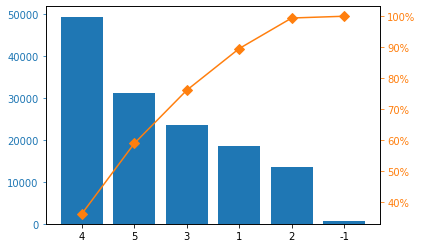

In [ ]:
create_pareto_diagram(df,"viewpoint")

In [ ]:
# Create dimensions
import plotly.graph_objects as go

make_id_dim = go.parcats.Dimension(
    values=df.make_id,
    categoryorder='category ascending', label="make_id"
      )
model_id_dim = go.parcats.Dimension(
    values=df.model_id,
    categoryorder='category ascending', label="model_id"
      )
released_year_dim = go.parcats.Dimension(
    values=df.released_year,
    categoryorder='category ascending', label="released_year"
      )
viewpoint_dim = go.parcats.Dimension(
    values=df.viewpoint,
    categoryorder='category ascending', label="viewpoint"
      )

fig = go.Figure(data = [go.Parcats(dimensions=[released_year_dim ,viewpoint_dim],
        # line={'color': color, 'colorscale': colorscale},
        hoveron='color', hoverinfo='count+probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.show()

In [ ]:
df_secure.dtypes

extension          object
image_name         object
make_id          category
model_id         category
released_year    category
viewpoint        category
nBoundingBox        int32
bbox               object
x1                  int32
y1                  int32
x2                  int32
y2                  int32
dtype: object

In [ ]:
df1=df_secure[["make_id","model_id","released_year","viewpoint"]]

In [ ]:
import pandas as pd
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
  
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histograma')
    ax1.set(xlabel=feature,ylabel=" cantidad de imágenes")

    ## plot the histogram. 
   # plt.hist(df.loc[:,feature], 20,)
    ax1.hist(df.loc[:,feature],30)
    
   # sns.distplot(df.loc[:,feature], norm_hist=False, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


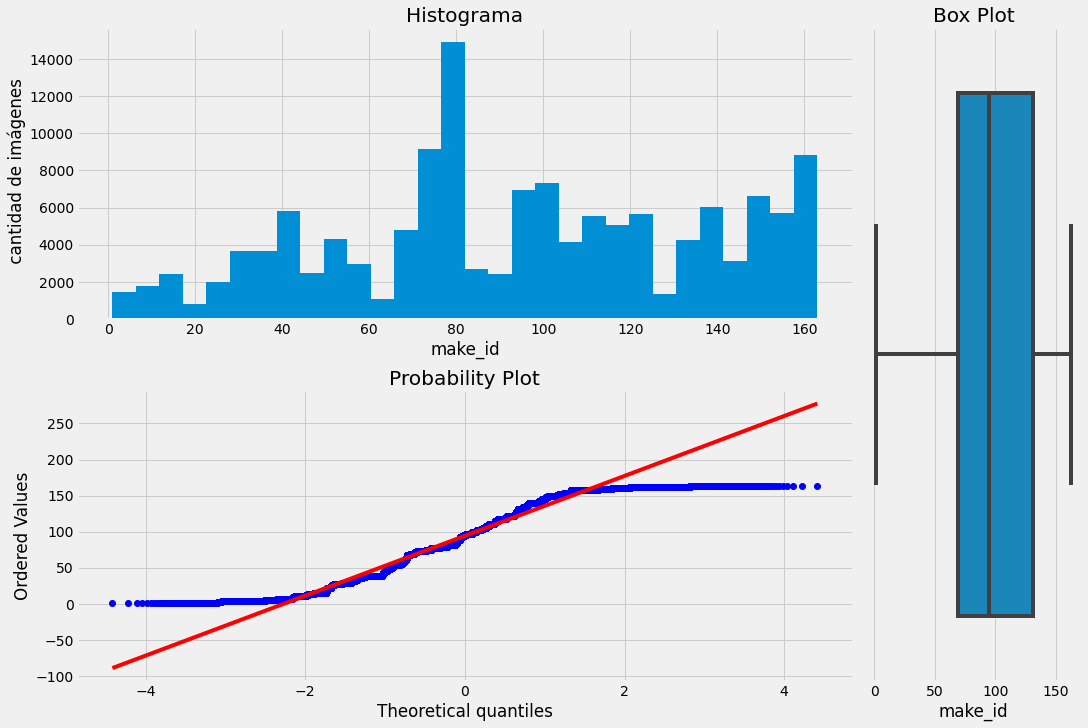

In [ ]:
plotting_3_chart(df, 'make_id')  

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


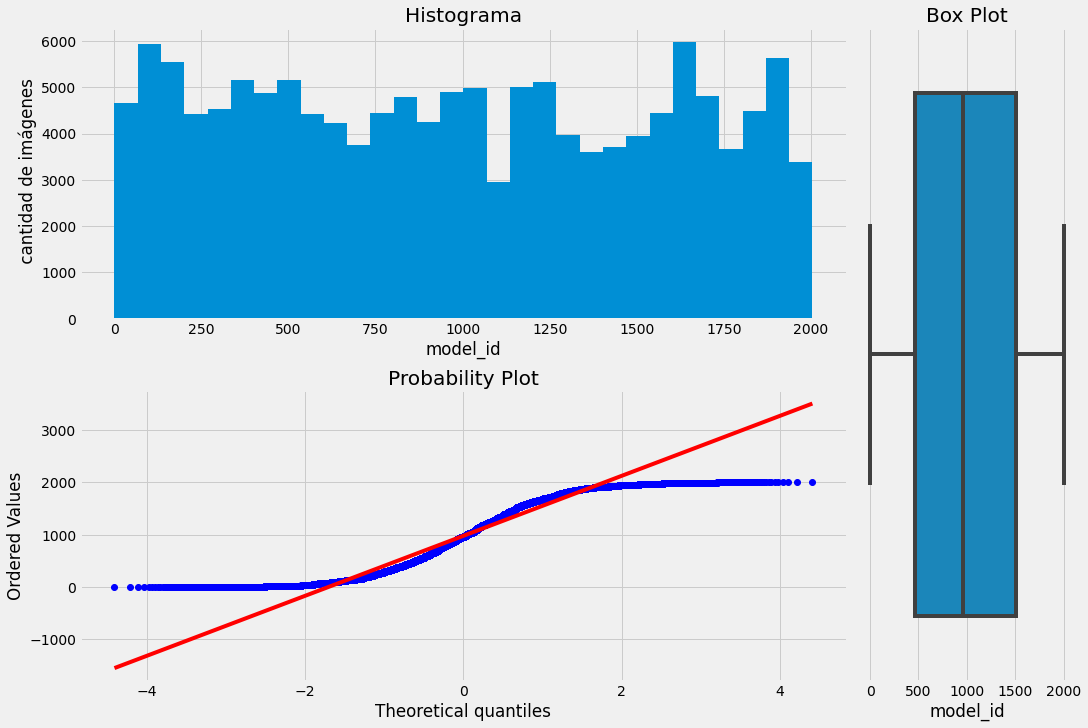

In [ ]:
plotting_3_chart(df, 'model_id')  

In [ ]:
plotting_3_chart(df, 'viewpoint')  

TypeError: ignored

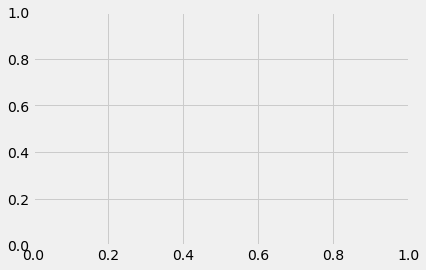

In [ ]:
import plotly.express as px

fig = px.parallel_categories(df,dimensions=["released_year"])

fig.show()

In [ ]:
df.dtypes

extension          object
image_name         object
make_id             int32
model_id            int32
released_year    category
viewpoint        category
nBoundingBox        int32
bbox               object
x1                  int32
y1                  int32
x2                  int32
y2                  int32
dtype: object